In [1]:
# Edgar new data Jan 2024

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

seed = 2468
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.get_device_name()

In [2]:
'''
The imaging is still at 30hz.
The ephys is binarized in 1ms bins.
The speed has corresponding triggers in imaging and ephys.
I.e. for every entry in the speed file, there is a corresponding imaging frame or ephys bin at the given index.
There are files for baseline and for stimulation. In each case, the imaging ROIs and the ephys units are matched.
I.e. index 1 in baseline imaging is the same cell as index 1 is stim imaging.

Please see if this format works for you. Let me know if you want me to downsample all of them to the same frame rate (30Hz) instead if that is easier for you. If this runs ok, then I can run another 1-2 mice through which should put us at 3-4 animals. I will work on getting the combinatorial paradigm in place as well, but it is a little bit complicated right now.
'''
area_ID_ephys = np.load('./data/biological/EB095/area_ID_ephys.npy')        # (106,) 8 LS, 70 ACC
dff_run = np.load('./data/biological/EB095/dff_run.npy')                    # (294, 33897) GCaMP when running
dff_stim = np.load('./data/biological/EB095/dff_stim.npy')                  # (294, 111810) GCaMP when stimulated 
spks_run = np.load('./data/biological/EB095/spks_run.npy')                  # (106, 1188000)
spks_stim = np.load('./data/biological/EB095/spks_stim.npy')                # (106, 3799862)
speed_run = np.load('./data/biological/EB095/speed_run.npy')                # (56302,) max 13

speed_triggers_ephys_run = np.load('./data/biological/EB095/speed_triggers_ephys_run.npy')  # (56322)
speed_triggers_img_run = np.load('./data/biological/EB095/speed_triggers_img_run.npy')      # (56322)
stim_ID = np.load('./data/biological/EB095/stim_ID.npy')                    # (300,), R S or F
stim_triggers_ephys_stim = np.load('./data/biological/EB095/stim_triggers_ephys_stim.npy')  # (300,)
stim_triggers_img_stim = np.load('./data/biological/EB095/stim_triggers_img_stim.npy')      # (300,)

Exploratory analysis: Running vs Activity

(array([34262.,  2050.,  2242.,  2476.,  2980.,  3948.,  3859.,  2978.,
         1293.,   214.]),
 array([ 0.        ,  1.47263641,  2.94527283,  4.41790924,  5.89054565,
         7.36318207,  8.83581848, 10.3084549 , 11.78109131, 13.25372772,
        14.72636414]),
 <BarContainer object of 10 artists>)

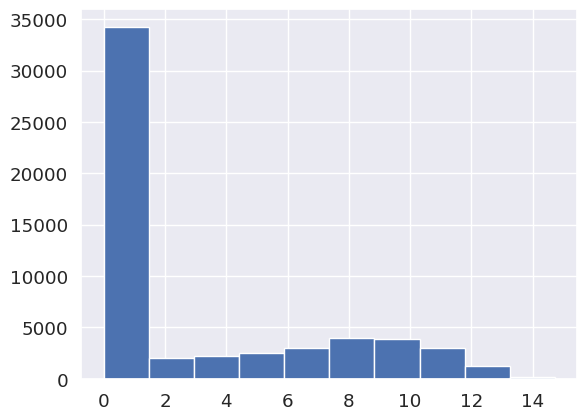

In [3]:
spks_run[:, speed_triggers_ephys_run] # (106, 56322)
plt.hist(speed_run) # (56302)

In [53]:
from utils import rbf_rate_convolution_2d
spks_run_30Hz_smooth = rbf_rate_convolution_2d(spks_run_30Hz.T, sigma=0.1)
spks_run_30Hz_smooth = np.hstack((np.zeros((106,50)), spks_run_30Hz_smooth))
spks_run_30Hz_smooth = np.hstack(( spks_run_30Hz_smooth, np.zeros((106,50))))


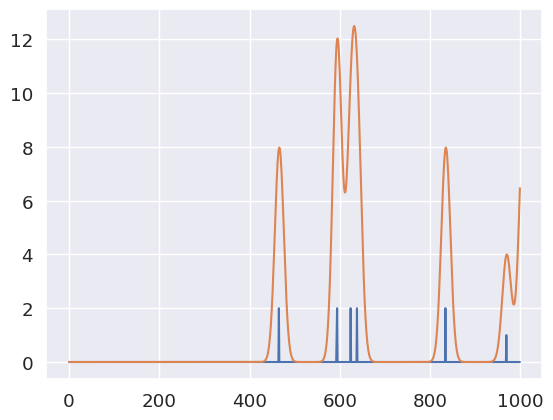

In [54]:
plt.plot(spks_run_30Hz[3,5000:6000])
plt.plot(spks_run_30Hz_smooth[3,5000:6000])

In [71]:
speed_triggers_ephys_run_30Hz = list(map(int, speed_triggers_ephys_run/freq))

In [72]:
speed_triggers_ephys_run_30Hz

[662,
 1095,
 1101,
 1102,
 1103,
 1103,
 1103,
 1104,
 1105,
 1106,
 1106,
 1107,
 1108,
 1108,
 1109,
 1110,
 1111,
 1111,
 1112,
 1113,
 1113,
 1114,
 1114,
 1115,
 1115,
 1116,
 1116,
 1117,
 1117,
 1118,
 1118,
 1119,
 1119,
 1120,
 1120,
 1121,
 1121,
 1122,
 1122,
 1123,
 1123,
 1124,
 1124,
 1125,
 1125,
 1126,
 1126,
 1127,
 1127,
 1128,
 1128,
 1129,
 1129,
 1130,
 1130,
 1131,
 1131,
 1132,
 1132,
 1133,
 1133,
 1134,
 1134,
 1135,
 1135,
 1136,
 1136,
 1137,
 1137,
 1138,
 1138,
 1139,
 1139,
 1140,
 1141,
 1141,
 1142,
 1142,
 1143,
 1143,
 1144,
 1145,
 1145,
 1146,
 1146,
 1147,
 1148,
 1148,
 1149,
 1149,
 1150,
 1151,
 1151,
 1152,
 1152,
 1153,
 1153,
 1154,
 1154,
 1155,
 1155,
 1156,
 1156,
 1157,
 1157,
 1158,
 1158,
 1159,
 1159,
 1160,
 1160,
 1161,
 1161,
 1162,
 1162,
 1163,
 1163,
 1164,
 1164,
 1165,
 1165,
 1166,
 1166,
 1167,
 1167,
 1168,
 1168,
 1169,
 1169,
 1170,
 1170,
 1171,
 1171,
 1172,
 1172,
 1173,
 1174,
 1174,
 1175,
 1175,
 1176,
 1176,
 1177,


Text(0, 0.5, 'Correlation')

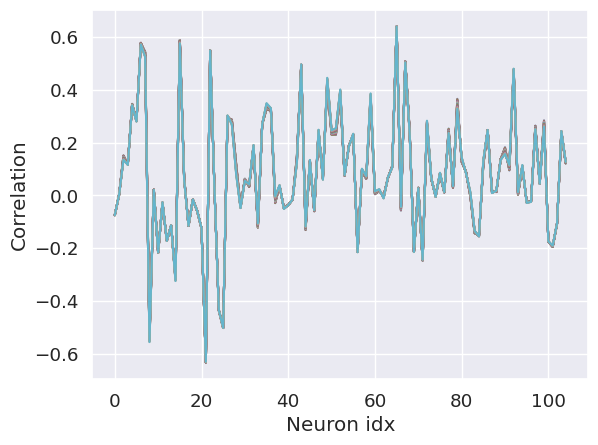

In [84]:
lag = 0

for lag in range(1, 21):
    corr = []
    for n in range(106):
        corr.append(np.corrcoef(spks_run_30Hz_smooth[n,speed_triggers_ephys_run_30Hz[lag:56322- (20-lag)]], speed_run)[0,1])
    plt.plot(corr[1:])
plt.xlabel('Neuron idx')
plt.ylabel('Correlation')

Naive model fitting:
Ignore running / stationary, fit model to both data.

In [12]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(stim_triggers_img_stim[:,None],stim_triggers_ephys_stim[:,None])
freq = lm.coef_[0][0] # * 1000 Hz
intercept = lm.intercept_ # succeeding time

In [28]:
spks_stim_30Hz = np.zeros((spks_stim.shape[0], int(spks_stim.shape[1]/freq))) # (106, 114141)
spks_run_30Hz = np.zeros((spks_stim.shape[0], int(spks_run.shape[1]/freq)))
# stim_triggers_ephys_stim_30Hz = np.array((stim_triggers_ephys_stim - intercept) / freq, dtype=np.int64)
for n in range(int(spks_stim.shape[1]/freq)):
    spks_stim_30Hz[:,n] = np.sum(spks_stim[:, int(n*freq): int((n+1)*freq)], axis=1)

for n in range(int(spks_run.shape[1]/freq)):
    spks_run_30Hz[:,n] = np.sum(spks_run[:, int(n*freq): int((n+1)*freq)], axis=1)

Convolve spikes

In [1]:
# truncate img and ephys such that they are aligned
total_time = None

In [12]:
from utils import rbf_rate_convolution_2d
ephys_rates = rbf_rate_convolution_2d(spks_stim_30Hz.T, sigma=0.1).T # [94257, 77]

# # pad
# one_sided_padding_steps = int((total_time - ephys_rates.shape[0]) / 2)
# one_sided_paddings = torch.zeros(one_sided_padding_steps, int(ephys_rates.shape[1]))
# ephys_rates = torch.vstack((one_sided_paddings,ephys_rates))
# ephys_rates = torch.vstack((ephys_rates, one_sided_paddings))

# img_array = dff_stim.T

# assert ephys_rates.shape[0] == total_time
# assert img_array.shape[0] == ephys_rates.shape[0]

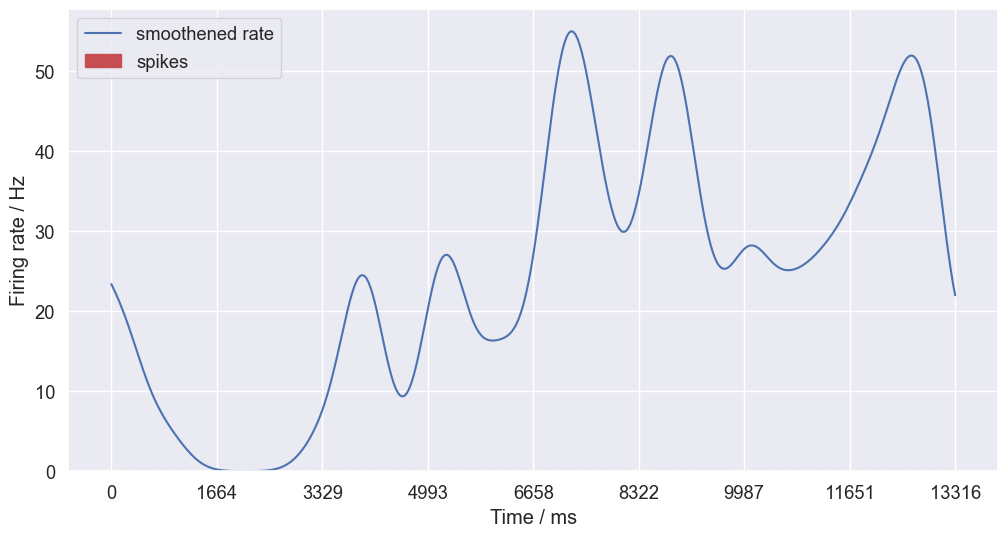

In [15]:
# plot a sample of ephys smooth rates
plt.figure(figsize=(12,6))
plt.plot(ephys_rates[50000:50401,15], label='smoothened rate')
plt.xticks(np.arange(0,401,50), [int(i*freq) for i in range(0, 401, 50)])
plt.bar(np.arange(401), height = spks_stim[15, 50000:50401] * ephys_rates[50000:50401,15].mean().numpy(), color='r', edgecolor='r', label='spikes')
plt.ylabel('Firing rate / Hz')
plt.xlabel('Time / ms')
plt.legend()
plt.show()

# 10 time steps = 1 sigma = 330 ms

Data Pre-processing

In [ ]:
tsteps = 15
cutoff_size = 2

assert ephys_rates.shape[0] == img_array.shape[0]

n_vecs = int(ephys_rates.shape[0] / tsteps)
input_dim = img_array.shape[1]
output_dim = ephys_rates.shape[1]
n_vecs = int(ephys_rates.shape[0]/tsteps)
n_stims = len(stim_time)

# pre-process data into train and test sets
inputs, targets = torch.zeros(n_vecs, tsteps, input_dim), torch.zeros(n_vecs, 1, output_dim)
ephys_rates = torch.as_tensor(ephys_rates)
img_array = torch.as_tensor(img_array)
for n in range(1, n_vecs):
    inputs[n,:,:] = img_array[n*tsteps:(n+1)*tsteps,:]
    targets[n,:,:] = ephys_rates[n*tsteps-3:n*tsteps-2,:]

inputs = inputs[1:]
targets = targets[1:]

stim_vecs_idx = np.array([int(stim_time[i]/15) for i in range(n_stims)])
non_stim_vecs_idx = []

for i in range(cutoff_size, n_vecs-cutoff_size):
    flag = True
    for j in range(i-cutoff_size, i+cutoff_size):
        if j in stim_vecs_idx:
            flag = False
    if flag:
        non_stim_vecs_idx.append(i)

non_stim_vecs_idx = [i for i in range(cutoff_size, n_vecs-cutoff_size) if i not in stim_vecs_idx] # exclude padding steps

We sample 200 endogenous activity vectors, delete 4 vectors (4 * 15 * 33 = 2 secs) steps before and after.

In [ ]:
test_set_idx = list(stim_vecs_idx)

# sample 200 endogenous data, chop off ends and add to test set
c = 0
while c < 200:
    endogenous_idx = np.random.choice(non_stim_vecs_idx)
    
    if np.all([x in non_stim_vecs_idx for x in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size)]):
        c += 1
        for i in range(endogenous_idx-cutoff_size, endogenous_idx+cutoff_size):
            non_stim_vecs_idx.remove(i)
        test_set_idx.append(endogenous_idx)
    
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

Train for LS neurons only

In [ ]:
# first 13 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[..., 0:13]
Y_test_LS = Y_test[..., 0:13]
output_dim = Y_train_LS.shape[-1]

batch_size = 4096
train_dataset = BNN_Dataset(X_train, Y_train_LS)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
# valid_dataset = BNN_Dataset(X_valid, Y_valid_LS)
# valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)

Bayes Opt

In [ ]:
run_bayes_opt = False
from bayes_opt import BayesianOptimization
from models import TransformerOneStep as TransformerDNN
from train import train_transformer, eval_transformer

def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerDNN(input_dim=input_dim,
                        d_model=d_model,
                        num_heads=num_heads,
                        hidden_dim=hidden_dim,
                        output_dim=output_dim,
                        n_layers=n_layers,
                        device=device,
                        pos_output=True,
                        use_mask=True,
                        dropout=0.1,
                        bin_output=False,
                        softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=25, threshold=0.01)


    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader, test_loader=valid_dataloader, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    return -min(return_dict['eval_losses'])

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=1)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if run_bayes_opt:
    run_bayes_opt(pbounds = {'d_model':(100, 1000),
               'num_heads':(1, 20),
               'hidden_dim':(100, 1000),
               'n_layers':(1, 5)}, init_points=50, n_iter=50)

Train Transformer

In [ ]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 62        | -163.6    | 221.1     | 848.9     | 5.0       | 20.0      |
# | 57        | -164.1    | 270.0     | 876.5     | 3.016     | 16.14     |


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep as TransformerDNN
DNN_LS = TransformerDNN(input_dim=input_dim,
                    d_model=220,
                    num_heads=20,
                    hidden_dim=848,
                    output_dim=output_dim,
                    n_layers=5,
                    device=device,
                    pos_output=True,
                    use_mask=False,
                    dropout=0.1,
                    bin_output=False,
                    softmax_output=False).to(device)

assert len(stim_id) == len(stim_vecs_idx)
forward_mse_idx = list(np.nonzero(np.array(stim_id) == 'a')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_id) == 'b')[0])
random_mse_idx = list(np.nonzero(np.array(stim_id) == 'c')[0])
non_stim_mse_idx = np.arange(len(stim_id), Y_test.shape[0])

assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0